In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.metrics import mean_squared_error
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Color images are acquired in three channels - Red (R), Green (G) and Blue (B). The data (image) acquired
by each of the channels is sparse in DCT or wavelet domain. i.e.,

\begin{equation}
C = \Phi^T \chi_C, C \in {R,G,B}\\
\chi_C = \Phi C
\end{equation}

Where C represent each of the three-color channels, $\Phi$ is the (sparsifying) transform matrix and X H is the
sparse transform coefficient for each color channel.


## 1.) 
In this problem, you are required to compress the color image (Lenna.png) to 70% of its original size
by using compressive sensing matrix A H (random sampling). The sensing matrix can be the same for all
channels. Define your own sensing matrix A H and plot the compressed color image.

In [2]:
'''
This code is refactored matlab code ported to Python done by 
Johnathan Tay. refactored code can be found here:
https://github.gatech.edu/jtay6/IYSE8803-Examples-Py/blob/master/Module%207/Examples7.py
'''
def dwt(N):
    g, h = pywt.Wavelet('sym8').filter_bank[:2]
    L = len(h)  # Length of bandwidth
    rank_max = int(np.log2(N))  # Maximum Layer
    rank_min = int(np.log2(L))+1  # Minimum Layes
    ww = np.eye(2**rank_max)  # Proprocessing Matrix

    for jj in range(rank_min, rank_max+1):
        nn = 2**jj
        # Construct vector
        p1_0 = np.concatenate([g, np.zeros(nn-L)])
        p2_0 = np.concatenate([h, np.zeros(nn-L)])
        p1 = []
        p2 = []
        # Circular move
        for ii in range(2**(jj-1)):
            shift = 2*ii
            p1.append(np.roll(p1_0, shift))
            p2.append(np.roll(p2_0, shift))
        p1 = np.stack(p1)
        p2 = np.stack(p2)
        # Orthogonal Matrix
        w1 = np.concatenate([p1, p2])
        wL = len(w1)
        w = np.eye(2**rank_max)
        w[:wL, :wL] = w1
        ww = ww@w
    return ww

def omp(s, T, N):
    T2 = T.copy()
    sz = T.shape  # Size of measurement Matrix
    M = sz[0]  # Measure
    hat_y = np.zeros(N)  # coefficients to be recovered
    selected_rows = []
    r_n = s  # error

    for times in range(M):  # Iteration number
        product = np.abs(T2.T@r_n)
        pos = np.argmax(product)
        selected_rows.append(pos)  # Find residual largest point
        Aug_t = T[:, selected_rows].reshape(M, -1)
        T2[:, pos] = 0  # zero out picked column
        aug_y = np.linalg.lstsq(Aug_t, s)[0]  # Least squares
        r_n = s-Aug_t@aug_y  # Residual
        if (abs(aug_y[-1])**2)/(aug_y@aug_y)**0.5 < 0.05:  # Find best error cut off
            break

    hat_y[selected_rows] = aug_y
    return hat_y

In [3]:
#Load and inspect image
X = plt.imread('Lenna.png').astype('float32')*1.0

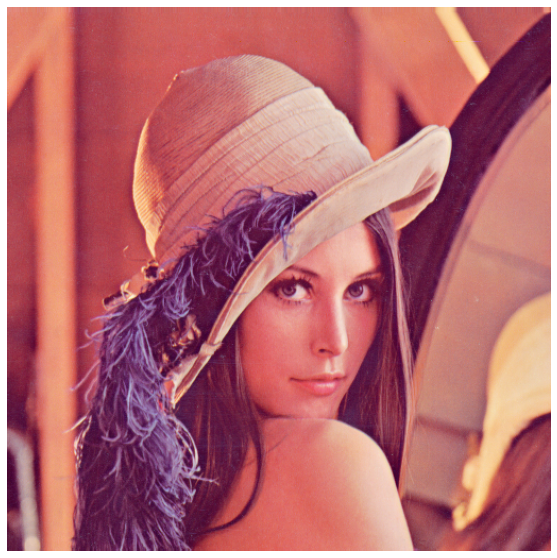

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(X)
plt.axis('off')
plt.show()

In [5]:
#Create a random sensing matrix from random Gaussian disribution
a,b = X[:,:,0].shape
M = int(0.7 * 512)
R = np.random.normal(size=(M,a))

print(R.shape)

(358, 512)


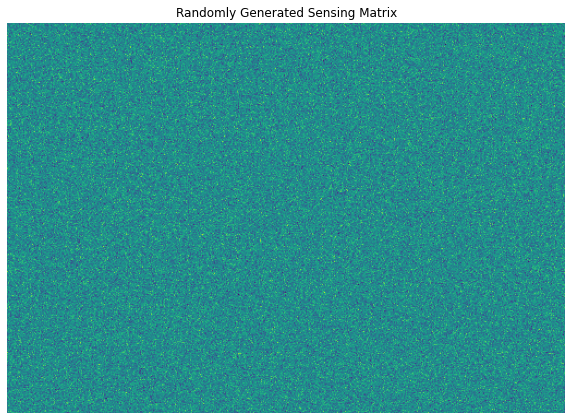

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(R)
plt.axis("off")
plt.title('Randomly Generated Sensing Matrix')
plt.show()

In [7]:
#measurement in original domain
Y1 = R@X[:,:,0]
Y2 = R@X[:,:,1]
Y3 = R@X[:,:,2]

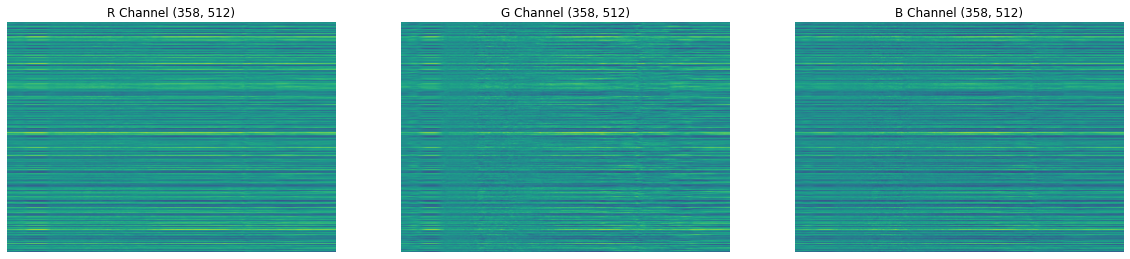

In [8]:
plt.subplots(1,3,figsize=(20,20))
plt.subplot(131)
plt.imshow(Y1)
plt.axis('off')
plt.title('R Channel {}'.format(Y1.shape))
plt.subplot(132)
plt.imshow(Y2)
plt.axis('off')
plt.title('G Channel {}'.format(Y2.shape))
plt.subplot(133)
plt.imshow(Y3)
plt.axis('off')
plt.title('B Channel {}'.format(Y3.shape))
plt.show()

In [9]:
ww = dwt(a)

In [10]:
Y1 = Y1@ww.T
Y2 = Y2@ww.T
Y3 = Y3@ww.T


R = R@ww.T

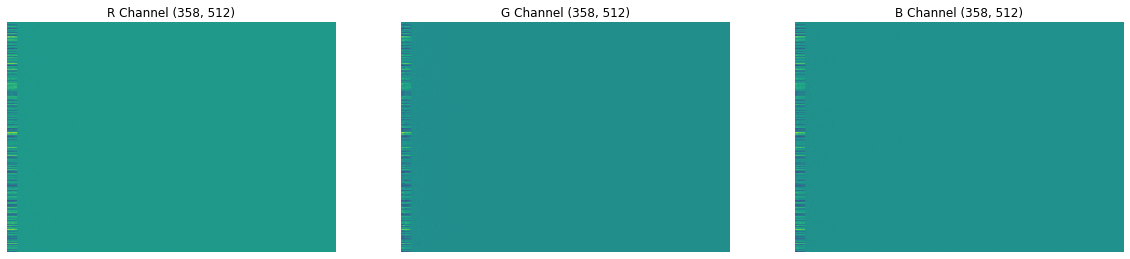

In [11]:
plt.subplots(1,3,figsize=(20,20))
plt.subplot(131)
plt.imshow(Y1)
plt.axis('off')
plt.title('R Channel {}'.format(Y1.shape))
plt.subplot(132)
plt.imshow(Y2)
plt.axis('off')
plt.title('G Channel {}'.format(Y2.shape))
plt.subplot(133)
plt.imshow(Y3)
plt.axis('off')
plt.title('B Channel {}'.format(Y3.shape))
plt.show()

## 2.)
In this problem, use the provided code DWT.m to generate the transform matrix $\Phi$ and recover the
color image. Compare the original color image with recovered color image. Compute the reconstruction
error in terms of MSE.

In [12]:
#OMP algorithm from sklearn

#R-channel
X2_1 = np.zeros((a, b))
reg = OrthogonalMatchingPursuit(n_nonzero_coefs=256,tol=1e-5, fit_intercept=False, normalize=False)
for i in range(b):
    reg.fit(R, Y1[:, i])
    X2_1[:, i] = reg.coef_
    
#G-channel  
X2_2 = np.zeros((a, b))
reg = OrthogonalMatchingPursuit(n_nonzero_coefs=256,tol=1e-5, fit_intercept=False, normalize=False)
for i in range(b):
    reg.fit(R, Y2[:, i])
    X2_2[:, i] = reg.coef_
    
#B-channel
X2_3 = np.zeros((a, b))
reg = OrthogonalMatchingPursuit(n_nonzero_coefs=256,tol=1e-5, fit_intercept=False, normalize=False)
for i in range(b):
    reg.fit(R, Y3[:, i])
    X2_3[:, i] = reg.coef_



In [13]:
X3_1 = ww.T@X2_1@ww
X3_2 = ww.T@X2_2@ww
X3_3 = ww.T@X2_3@ww

reconstruction = np.dstack([X3_1, X3_2, X3_3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


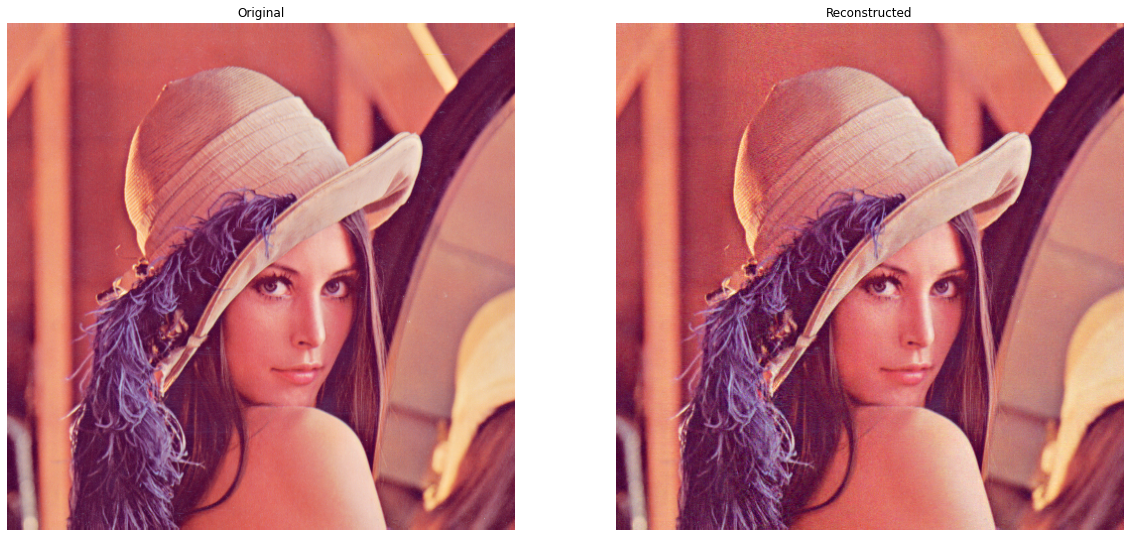

In [14]:
plt.subplots(1,2,figsize=(20,10))
plt.subplot(121)
plt.imshow(X)
plt.axis('off')
plt.title('Original')
plt.subplot(122)
plt.imshow(reconstruction)
plt.axis('off')
plt.title('Reconstructed')
plt.show()

### Mean Squared Error -> dtype = float32

In [15]:
print('MSE: {}'.format(mean_squared_error(X.reshape(-1,1), reconstruction.reshape(-1,1))))

MSE: 0.000569998030167796


### Mean Squared Error -> dtype = uint8

In [16]:
print('MSE: {}'.format(mean_squared_error((X.reshape(-1,1)*255).astype('uint8'), (reconstruction.reshape(-1,1)*255).astype('uint8'))))

MSE: 29.488072713216145
